# Курсовая работа

### Требования  
**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и построения признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

***подключим основные библиотеки***

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import chi2_contingency
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold,RandomizedSearchCV
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb


#### Пути до файлов с данными 

In [2]:
data_train_path = './data/course_project_train.csv'
data_test_path = './data/course_project_test.csv'
scaler_file = './data/scaler_model'
MODEL_FILE_PATH = './data/final_model'
pred_data = './data/pred_data.csv'


### Постановка задачи  
> Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

### Описание датасета  


* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - баллы кредитного рейтинга
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Загрузка обучающего и тестового датасетов 

In [3]:
df_base= pd.read_csv(data_train_path)
df_test= pd.read_csv(data_test_path)
df_base.head(5)


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


### Общая информация по датасету

In [4]:
print(df_base.shape)
print(df_test.shape)

(7500, 17)
(2500, 16)


In [5]:
target_name = 'Credit Default'
feature_names = df_base.columns.drop('Credit Default').to_list()

In [6]:
df_base.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [7]:
df_base.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


Обучающий и тестовы дайтасеты содержат одинаковые наборы признаков.  ***Credit Default*** - целевая переменная обучающего дататасета.  
12 количественных признаков и 4 номинантных.  


### Обработка пропусков и выбросов


In [8]:
df_base.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

Большое значение пропусков в Months since last delinquent можно объяснить  отсутствием просрочек с погашением платежа. Поэтому заменяем соответсвующие позиции на нулевые значения.  
Credit Default,  Annual Income, Years in current job и Bankruptcie свидетельствуют о не полноте информации. Credit Default,  Annual Income,  и Bankruptcie заменяем своими медианными значениями, а Years in current job - своей модой.  
Значение 1E8 в Current Loan Amount по всей видимсости является выбросом и будет заменен на медианное значение.


In [9]:
df_base.loc[df_base.isna()['Years in current job'], 'Years in current job'] = df_base['Years in current job'].mode()[0]
df_base.loc[df_base.isna()['Annual Income'], 'Annual Income'] = df_base['Annual Income'].median()
df_base.loc[df_base.isna()['Credit Score'], 'Credit Score'] = df_base['Credit Score'].median()
df_base.loc[df_base.isna()['Bankruptcies'], 'Bankruptcies'] = df_base['Bankruptcies'].median()
df_base.loc[df_base.isna()['Months since last delinquent'], 'Months since last delinquent'] = 0
df_base.loc[df_base['Current Loan Amount']==df_base['Current Loan Amount'].max(), 'Current Loan Amount'] = df_base['Current Loan Amount'].median()

Удалим повторяющиеся строки

In [10]:
df_base.drop_duplicates(inplace=True)

### Отбор признаков

In [11]:
target_name = 'Credit Default'
feature_names = df_base.columns.drop('Credit Default').to_list()

#### Номинативные прзнаки.  
* **Home Ownership** - домовладение
* **Years in current job** - количество лет на текущем месте работы
* **Purpose** - цель кредита
* **Term** - срок кредита  
Для этих данных имеет смысл преобразование к строковому типу. 

In [12]:
CAT_FEATURES_NAMES = ['Home Ownership','Years in current job','Purpose', 'Term' ]
df_base[CAT_FEATURES_NAMES].astype(str)

,Home Ownership,Years in current job,Purpose,Term
0,Own Home,10+ years,debt consolidation,Short Term
1,Own Home,10+ years,debt consolidation,Long Term
2,Home Mortgage,8 years,debt consolidation,Short Term
3,Own Home,6 years,debt consolidation,Short Term
4,Rent,8 years,debt consolidation,Short Term
...,...,...,...,...
7495,Rent,< 1 year,other,Short Term
7496,Home Mortgage,1 year,debt consolidation,Long Term
7497,Rent,6 years,buy a car,Short Term
7498,Home Mortgage,10+ years,debt consolidation,Short Term


#### 12 количественных признаков.

In [13]:
NUM_FEATURES_NAMES = df_base[feature_names].columns.drop(CAT_FEATURES_NAMES).to_list()
print(NUM_FEATURES_NAMES)

['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']


### Анализ целевой переменной

In [14]:
df_base[target_name].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

5387 человек погасили кредит, а 2113 нет. Имеется  разбалансировка классов. 

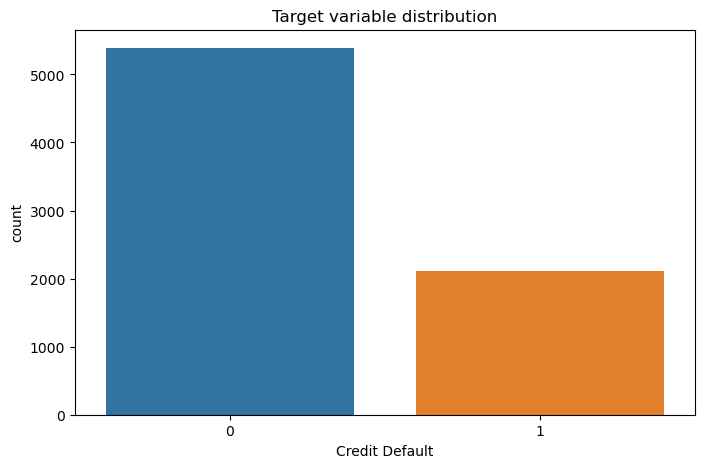

In [15]:
plt.figure(figsize=(8, 5))

sns.countplot(x=target_name, data=df_base)

plt.title('Target variable distribution')
plt.show()













#### Корреляция с базовыми прзнаками

In [16]:
korr_with_features = df_base[feature_names + [target_name]].corr().iloc[:-1,-1].sort_values(ascending = False)

/home/andrey/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


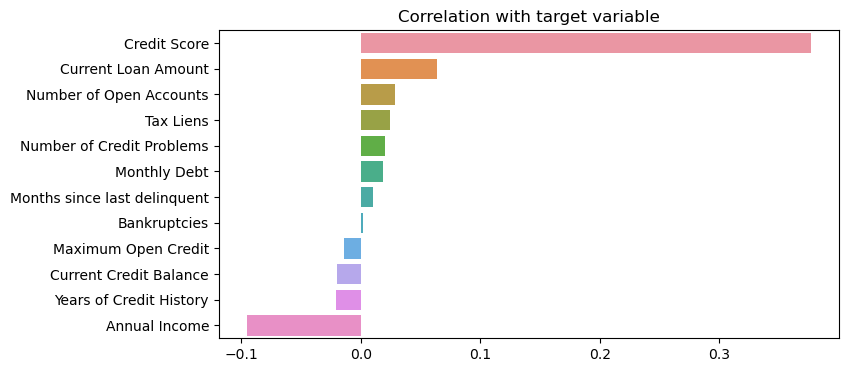

In [17]:
plt.figure(figsize=(8,4))
sns.barplot(korr_with_features.values, korr_with_features.index)
plt.title('Correlation with target variable')
plt.show()

**Наблюдается достаточно сильная линецйная зависимость между Credit Score и целевой переменной. Раассмоттрим, как соотносятся признаки с целевой переменной.**

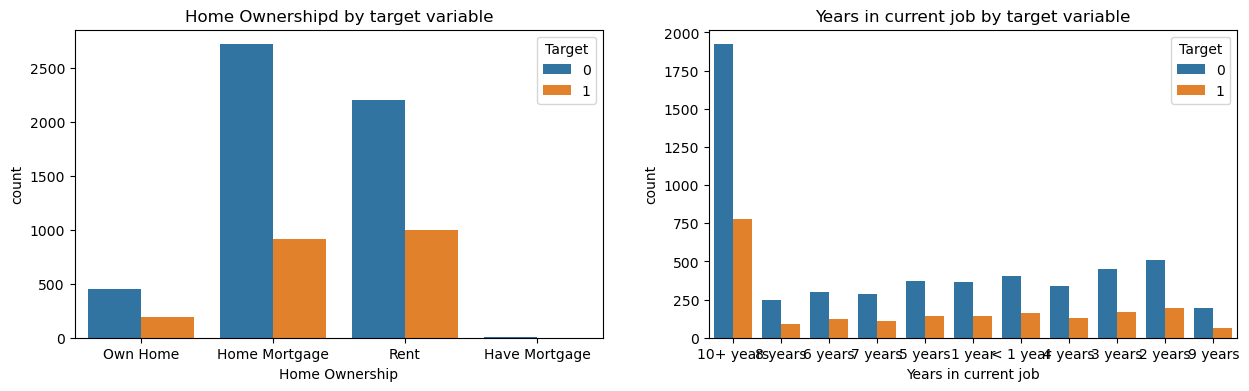

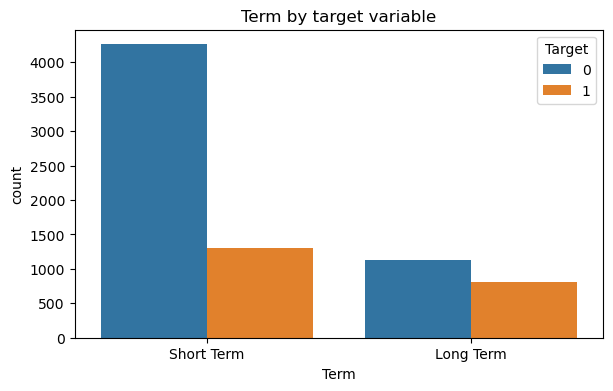

In [18]:
plt.figure(figsize=(15,4))
plt.subplot(121)

sns.countplot(x='Home Ownership',  hue=target_name, data=df_base)
plt.title('Home Ownershipd by target variable')
plt.legend(title='Target', loc='upper right')

plt.subplot(122)

sns.countplot(x='Years in current job',  hue=target_name, data=df_base)
plt.title('Years in current job by target variable')
plt.legend(title='Target', loc='upper right')
plt.show()

plt.figure(figsize=(15,4))
plt.subplot(121)



sns.countplot(x='Term',  hue=target_name, data=df_base)
plt.title('Term by target variable')
plt.legend(title='Target', loc='upper right')
plt.show()

Видно, что в разрезе целевой  переменной Target значения  Years in current job имеют одинаковое распределение. Если это так, то их можно объединить в одну категорию. Проверим эту версию.  

**Гипотеза** 
* Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы
* Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
* Критерий: Хи-квадрат Пирсона
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Функция ***getCategoryPirson*** проверяет по критерию Пирсона в разрезе целевой переменной  значения Years in current job. 

In [19]:
def getCategoryPirson(df_base,categor,listSign):
    outPirson = []
    for ind in range(1,len(listSign)):
        YearsInCurrentJob_target  = df_base.loc[df_base[categor].isin([listSign[0],listSign[ind]]),[categor,target_name]]
        YearsInCurrentJob_target.loc[:,"ID"] =  range(0,YearsInCurrentJob_target.shape[0])
        #print(YearsInCurrentJob_target)
        table = YearsInCurrentJob_target.pivot_table(values="ID", index=categor, columns=target_name,aggfunc='count')
        chi2, p, dof, expected = chi2_contingency(table, correction=False)
        outPirson.append(p)
    return outPirson
        
        

In [20]:
listSign =df_base['Years in current job'].unique()
print(getCategoryPirson(df_base, 'Years in current job',listSign))

[0.5006792539687488, 0.9278024493031297, 0.7229927702903716, 0.7153581004379619, 0.7433533661741736, 0.7558137032240556, 0.6708837607462488, 0.4637977656525255, 0.42691832656473505, 0.19621866915193914]


В соответствии с критерием Пирсона ни для одной пары нулевую гипотезу отвергнуть нельзя. Значит все категории можно объединить в одну и данный признак неинформативен.


In [21]:
df_base.drop('Years in current job', axis=1, inplace=True)


In [22]:
df_base.head()

,Home Ownership,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,debt consolidation,Short Term,309573.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,debt consolidation,Short Term,309573.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


### Построение новых признаков

In [23]:
df_base.dtypes

Home Ownership                   object
Annual Income                   float64
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [24]:
df_base_new = df_base.copy()
df_base_new['Home Ownership']= df_base_new['Home Ownership'].map({'Own Home':'1', 'Home Mortgage':'2', 'Rent':'3', 'Have Mortgage':'4'})
df_base_new['Purpose']= df_base_new['Purpose'].map({'debt consolidation':'1', 'other':'2', 'home improvements':'3', 'take a trip':'4',
       'buy a car':'5', 'small business':'6', 'business loan':'7', 'wedding':'8',
                                                       'educational expenses':'9', 'buy house':'10', 'medical bills':'11', 'moving':'12',
                                                       'major purchase':'13', 'vacation':'14'})
df_base_new['Term']= df_base_new['Term'].map({'Short Term':'1', 'Long Term':'2'})



for cat_colname in df_base_new.select_dtypes(include='object').columns:    
    df_base_new = pd.concat([df_base_new, pd.get_dummies(df_base_new[cat_colname], prefix=cat_colname)], axis=1)

In [25]:
df_base_new.drop(columns=['Home Ownership','Purpose','Term'], inplace=True)

In [26]:
feature_names_new = df_base_new.columns.drop(target_name).to_list()

In [27]:
print(feature_names_new)

['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Home Ownership_1', 'Home Ownership_2', 'Home Ownership_3', 'Home Ownership_4', 'Purpose_1', 'Purpose_10', 'Purpose_11', 'Purpose_12', 'Purpose_13', 'Purpose_14', 'Purpose_2', 'Purpose_3', 'Purpose_4', 'Purpose_5', 'Purpose_6', 'Purpose_7', 'Purpose_8', 'Purpose_9', 'Term_1', 'Term_2']


### Разбиение выборки на train и test

In [28]:
X = df_base_new[feature_names_new]
y = df_base_new[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

### Нормализация данных

In [29]:
scaler = StandardScaler()
X_tempo = X_train.copy()
#print(type(X_test))
X_tempo[:] = scaler.fit_transform(X_tempo) #обучили и нормализовали
X_train = X_tempo.copy()
X_tempo = X_test.copy()
X_tempo[:] = scaler.transform(X_tempo) # нормализовали
X_test = X_tempo.copy()



### Сохранение модели нормализации

In [30]:
with open(scaler_file, 'wb') as file:
    pickle.dump(scaler,file)

### Балансировка целевой переменной

In [31]:
# Функция, осуществляющая балансировку методом overSampling
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()
    #print(target_counts,"kkkk")

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()
    #print(major_class_name ,"jjjjjjjjjjjjjj")

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)
       # print(target_counts[minor_class_name])

    return df.sample(frac=1) 

In [32]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target_name)
    
df_balanced[target_name].value_counts()


/tmp/ipykernel_11977/837632461.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(sample, ignore_index=True)


0    3771
1    2958
Name: Credit Default, dtype: int64

In [33]:
X_train = df_balanced.drop(columns = target_name)
y_train = df_balanced[target_name]

### Построение и оценка базовых моделей

In [34]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

**Логистическая регрессия**

In [35]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.67      0.86      0.75      3771
           1       0.72      0.46      0.56      2958

    accuracy                           0.68      6729
   macro avg       0.69      0.66      0.66      6729
weighted avg       0.69      0.68      0.67      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.85      0.83      1616
           1       0.55      0.45      0.50       634

    accuracy                           0.74      2250
   macro avg       0.67      0.65      0.66      2250
weighted avg       0.73      0.74      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1378  238
1                346  288


**k ближайших соседей**

In [36]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

/home/andrey/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


TRAIN

              precision    recall  f1-score   support

           0       0.78      0.86      0.82      3771
           1       0.79      0.69      0.74      2958

    accuracy                           0.78      6729
   macro avg       0.78      0.77      0.78      6729
weighted avg       0.78      0.78      0.78      6729

TEST

              precision    recall  f1-score   support

           0       0.78      0.77      0.77      1616
           1       0.43      0.45      0.44       634

    accuracy                           0.68      2250
   macro avg       0.61      0.61      0.61      2250
weighted avg       0.68      0.68      0.68      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1242  374
1                349  285


/home/andrey/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


**Бустинговые алгоритмы**

XGBoost

In [37]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3771
           1       0.98      0.97      0.98      2958

    accuracy                           0.98      6729
   macro avg       0.98      0.98      0.98      6729
weighted avg       0.98      0.98      0.98      6729

TEST

              precision    recall  f1-score   support

           0       0.79      0.85      0.82      1616
           1       0.52      0.43      0.47       634

    accuracy                           0.73      2250
   macro avg       0.66      0.64      0.65      2250
weighted avg       0.72      0.73      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1367  249
1                360  274


LightGBM

In [38]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.96      0.93      3771
           1       0.95      0.88      0.91      2958

    accuracy                           0.92      6729
   macro avg       0.93      0.92      0.92      6729
weighted avg       0.93      0.92      0.92      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1616
           1       0.54      0.46      0.50       634

    accuracy                           0.74      2250
   macro avg       0.67      0.65      0.66      2250
weighted avg       0.73      0.74      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1372  244
1                344  290


CatBoost

In [39]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      3771
           1       0.94      0.85      0.89      2958

    accuracy                           0.91      6729
   macro avg       0.91      0.90      0.90      6729
weighted avg       0.91      0.91      0.91      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1616
           1       0.54      0.44      0.49       634

    accuracy                           0.74      2250
   macro avg       0.67      0.65      0.66      2250
weighted avg       0.72      0.74      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1381  235
1                354  280


### Выбор лучшей модели и подбор гиперпараметров

In [40]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=30)

**Подбор гиперпараметров**

In [41]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7]}

In [42]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [43]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

CPU times: user 4.47 s, sys: 1.62 s, total: 6.09 s
Wall time: 45.2 s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x7ff76ccdad00>,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000, 1200, 1500]},
                   scoring='f1')

In [44]:
rs.best_params_

{'n_estimators': 500, 'max_depth': 5}

In [45]:
rs.best_score_

0.5416573905312809

**Обучение и оценка финальной модели**

In [46]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.88      0.81      3771
           1       0.81      0.64      0.71      2958

    accuracy                           0.77      6729
   macro avg       0.78      0.76      0.76      6729
weighted avg       0.78      0.77      0.77      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.84      0.83      1616
           1       0.55      0.49      0.52       634

    accuracy                           0.74      2250
   macro avg       0.68      0.67      0.67      2250
weighted avg       0.74      0.74      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1362  254
1                321  313
CPU times: user 3.05 s, sys: 1.21 s, total: 4.26 s
Wall time: 1.03 s


### Снижение степени переобучения

по всем трем показателям (precision    recall  f1-score) для категории 1 целевой переменной значения по тестовой выборке хуже, чем аналогичные значения для обучающей выборки, что говорит о перобучении  
Снизим переобучение с помощью l1-регуляризацияя.

In [47]:
final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3,
                                      l2_leaf_reg=10,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.87      0.79      3771
           1       0.78      0.59      0.67      2958

    accuracy                           0.75      6729
   macro avg       0.76      0.73      0.73      6729
weighted avg       0.75      0.75      0.74      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1616
           1       0.55      0.48      0.52       634

    accuracy                           0.74      2250
   macro avg       0.68      0.66      0.67      2250
weighted avg       0.73      0.74      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1368  248
1                328  306


### Важность признаков

In [48]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

/home/andrey/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


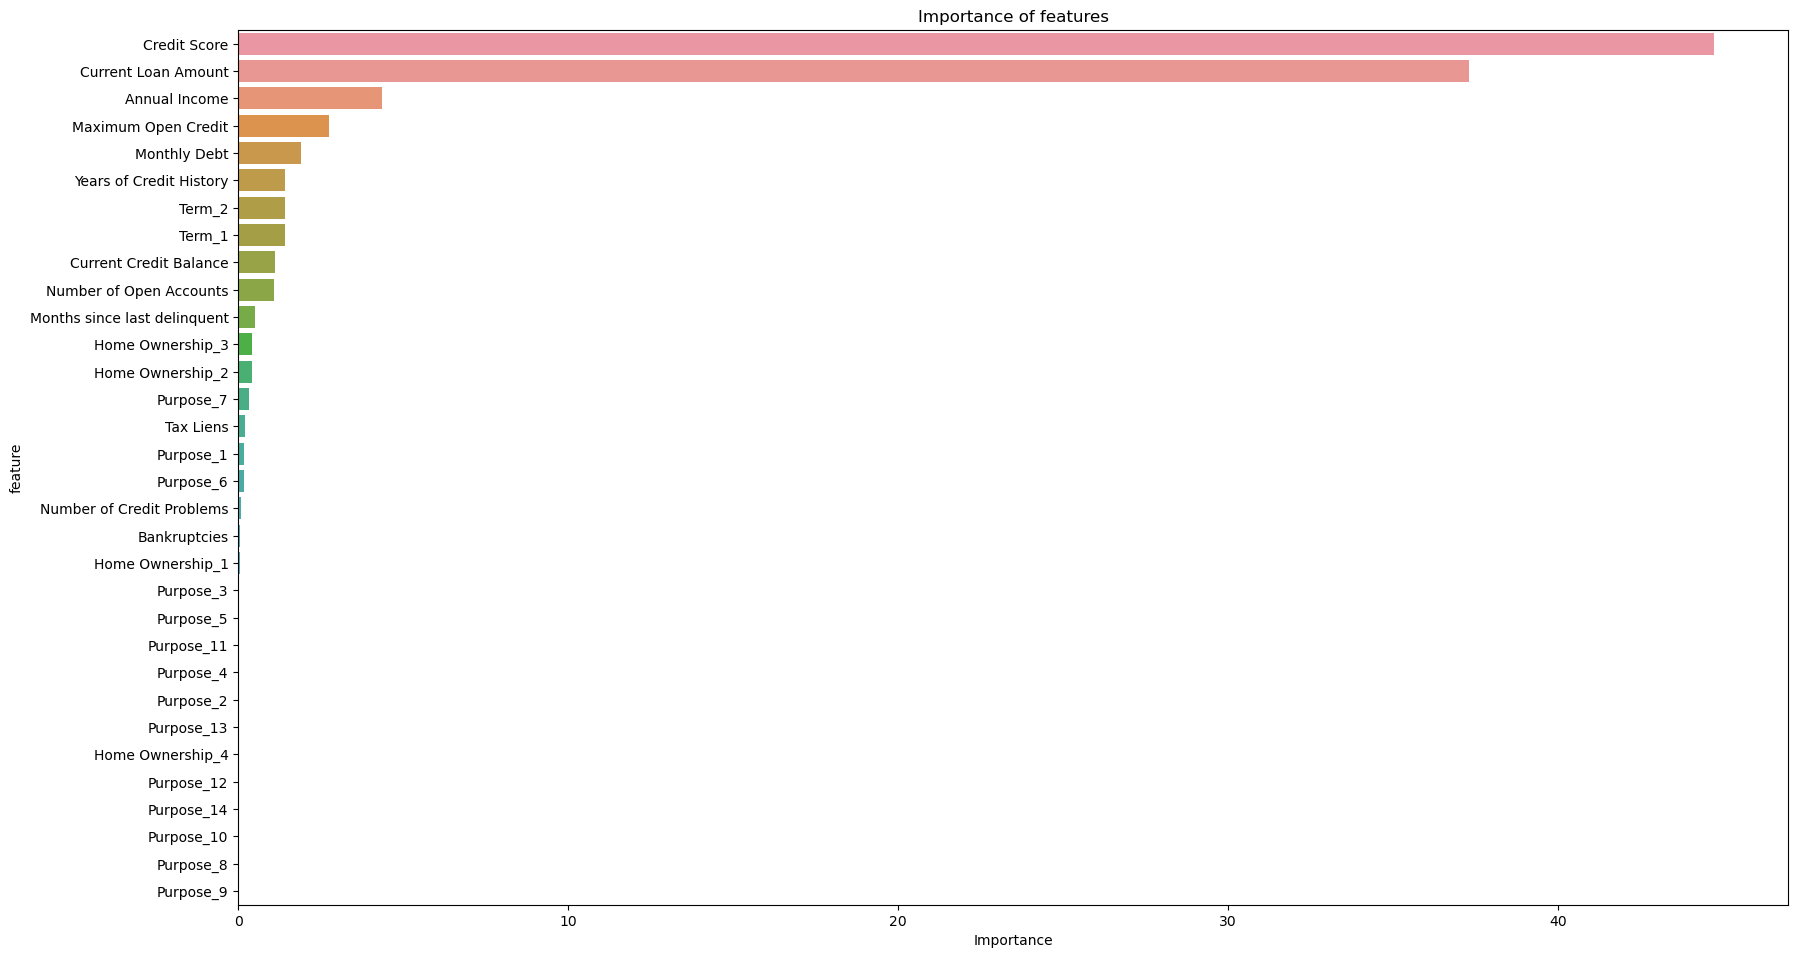

In [49]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=15)

In [50]:
important_features_top

['Credit Score',
 'Current Loan Amount',
 'Annual Income',
 'Maximum Open Credit',
 'Monthly Debt',
 'Years of Credit History',
 'Term_2',
 'Term_1',
 'Current Credit Balance',
 'Number of Open Accounts',
 'Months since last delinquent',
 'Home Ownership_3',
 'Home Ownership_2',
 'Purpose_7',
 'Tax Liens']

### Финальная модель

In [51]:
final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3, l2_leaf_reg=10,
                                      silent=True, random_state=21)
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.87      0.79      3771
           1       0.78      0.59      0.67      2958

    accuracy                           0.75      6729
   macro avg       0.75      0.73      0.73      6729
weighted avg       0.75      0.75      0.74      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.84      0.83      1616
           1       0.55      0.49      0.52       634

    accuracy                           0.75      2250
   macro avg       0.68      0.67      0.67      2250
weighted avg       0.74      0.75      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1365  251
1                322  312


### Сохранение финальной модели

In [52]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

### Подготовка тестового датасета

In [53]:
df_test[CAT_FEATURES_NAMES].astype(str)
df_test.drop('Years in current job', axis=1, inplace=True)
df_test.loc[df_test.isna()['Annual Income'], 'Annual Income'] = df_test['Annual Income'].median()
df_test.loc[df_test.isna()['Credit Score'], 'Credit Score'] = df_test['Credit Score'].median()
df_test.loc[df_test.isna()['Bankruptcies'], 'Bankruptcies'] = df_test['Bankruptcies'].median()
df_test.loc[df_test.isna()['Months since last delinquent'], 'Months since last delinquent'] = 0


In [54]:
df_test['Home Ownership']= df_test['Home Ownership'].map({'Own Home':'1', 'Home Mortgage':'2', 'Rent':'3', 'Have Mortgage':'4'})
df_test['Purpose']= df_test['Purpose'].map({'debt consolidation':'1', 'other':'2', 'home improvements':'3', 'take a trip':'4',
       'buy a car':'5', 'small business':'6', 'business loan':'7', 'wedding':'8',
                                                       'educational expenses':'9', 'buy house':'10', 'medical bills':'11', 'moving':'12',
                                                       'major purchase':'13', 'vacation':'14'})
df_test['Term']= df_test['Term'].map({'Short Term':'1', 'Long Term':'2'})



for cat_colname in df_test.select_dtypes(include='object').columns:    
    df_test = pd.concat([df_test, pd.get_dummies(df_test[cat_colname], prefix=cat_colname)], axis=1)

In [55]:
df_test.drop(columns=['Home Ownership','Purpose','Term'], inplace=True)

In [56]:
X_tempo = df_test.copy()
X_tempo[:] = scaler.transform(X_tempo) # нормализовали
df_test= X_tempo.copy()


In [57]:
y_test_pred = pd.DataFrame(final_model.predict(df_test[important_features_top]), columns=['Credit Default'])

In [58]:
df_pred = pd.concat([df_test,y_test_pred],axis=1)
df_pred

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,...,Purpose_3,Purpose_4,Purpose_5,Purpose_6,Purpose_7,Purpose_8,Purpose_9,Term_1,Term_2,Credit Default
0,-0.198253,-0.112569,-0.435267,-0.829106,-0.043420,-0.339902,2.400847,-0.338096,-0.855808,-0.573950,...,-0.242682,-0.06487,-0.113696,-0.061839,-0.132812,-0.045822,-0.036539,0.593629,-0.593629,0
1,-1.483346,-0.112569,-1.044424,2.041856,-0.052046,-0.339902,-0.344014,-0.338096,-1.339559,-0.760178,...,-0.242682,-0.06487,-0.113696,-0.061839,-0.132812,-0.045822,27.367864,0.593629,-0.593629,1
2,-0.233460,-0.112569,-0.232214,-0.658553,-0.044276,-0.339902,-0.698190,-0.338096,-0.639094,-0.447710,...,-0.242682,-0.06487,-0.113696,-0.061839,-0.132812,-0.045822,-0.036539,0.593629,-0.593629,1
3,-0.141456,-0.112569,0.986099,-0.189535,-0.031120,-0.339902,2.400847,-0.338096,-0.540219,-0.240205,...,-0.242682,-0.06487,-0.113696,-0.061839,-0.132812,-0.045822,-0.036539,0.593629,-0.593629,0
4,1.379852,-0.112569,-0.029162,0.748502,0.008131,-0.339902,-0.698190,-0.338096,2.679643,0.419836,...,-0.242682,-0.06487,-0.113696,-0.061839,-0.132812,-0.045822,-0.036539,-1.684553,1.684553,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,-0.413316,-0.112569,0.579995,1.530200,-0.025744,1.690228,2.312303,2.630140,572.927225,-0.397178,...,-0.242682,-0.06487,-0.113696,-0.061839,-0.132812,-0.045822,-0.036539,0.593629,-0.593629,0
2496,-0.198253,-0.112569,0.783047,-0.189535,0.035860,-0.339902,2.710750,-0.338096,0.903067,3.573593,...,-0.242682,-0.06487,-0.113696,-0.061839,-0.132812,-0.045822,-0.036539,0.593629,-0.593629,1
2497,-0.207306,-0.112569,7.483774,-0.786468,0.034221,-0.339902,-0.698190,-0.338096,0.684582,1.200740,...,-0.242682,-0.06487,-0.113696,-0.061839,-0.132812,-0.045822,-0.036539,0.593629,-0.593629,1
2498,-0.815870,-0.112569,0.579995,1.487562,-0.005536,-0.339902,-0.698190,-0.338096,-0.308080,0.313632,...,-0.242682,-0.06487,-0.113696,-0.061839,-0.132812,-0.045822,-0.036539,0.593629,-0.593629,0


Сохраним таблицу в csv-файл.


In [59]:
df_pred.to_csv(pred_data)